# fmdtools Tutorial

This tutorial notebook will show some of the basic commands needed to perform resilience analysis in fmdtools.

For some context, it may be helpful to look through the accompanying presentation. This notebook uses the model defined in `ex_pump.py`. In this notebook, we will:

- Load an environment and model
- Simulate the system in nominal and faulty scenarios
- Visualize and quantify the results

## 1.) Loading the environment and model

To load the `fmdtools` environment, we have to install and import it. This can be accomplished using `pip` for both the stable and development versions:

In [1]:
##Stable (PyPl) version
# pip install fmdtools

##Development version (downloaded from git)
# pip install -e /path/to/fmdtools ##Note that /path/to/fmdtools is the path to the fmdtools repo

There are a number of different syntaxes for importing modules. Because of the long names of the module trees, it is often helpful to load the modules individually and abbreviate (e.g. ``import fmdtools.sim.propagate as propagate``). Below, import the propagate `fmdtools.sim.propagate` and `fmdtools.analyze` modules, as well as the `SampleApproach` from `fmdtools.define`

In [3]:
import fmdtools.sim.propagate as propagate
from fmdtools.sim.approach import SampleApproach
import fmdtools.analyze as an

Now, import the Pump class defined in the ex_pump module.

In [4]:
from ex_pump import Pump

We can then use that to instantiate a model object. See:

To get started, it can be helpful to view some of the aspects of the model. Try `dir(mdl)`, `mdl.fxns`, `mdl.flows`, `mdl.graph`, etc.

{'import_ee': import_ee ImportEE
 - ImportEEState(effstate=1.0)
 - ImportEEMode(mode=nominal, faults=set()),
 'import_water': import_water ImportWater
 - State()
 - ImportWaterMode(mode=nominal, faults=set()),
 'import_signal': import_signal ImportSig
 - State()
 - ImportSigMode(mode=nominal, faults=set()),
 'move_water': move_water MoveWat
 - MoveWatStates(eff=1.0)
 - MoveWatMode(mode=nominal, faults=set()),
 'export_water': export_water ExportWater
 - State()
 - ExportWaterMode(mode=nominal, faults=set())}

We can also view the run order to see how the model will be simulated. More details on run order are provided in [Model Structure Visualization Tutorial](../docs/Model_Structure_Visualization_Tutorial.ipynb), but in short static propagation functions simulate multiple times per time-step until the model converges, while dynamic propagation functions run once per timestep in a defined order.

(<Figure size 864x720 with 1 Axes>, <AxesSubplot:>)

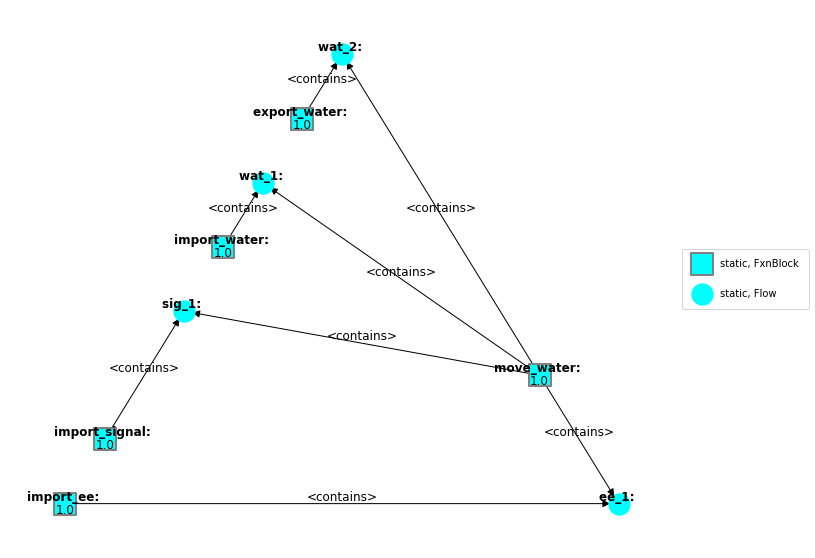

As shown, because all of the methods were defined as generic behaviors, they are each run in the static propagation step. No order is shown in the static step because the static propagation step iterates between model functions until the values have converged. Nevertheless, one can view the initial static order using:

OrderedSet(['import_ee', 'import_water', 'import_signal', 'move_water', 'export_water'])

and the dynamic step order (if there was one):

OrderedSet()

We can also instantiate this model with different parameters. In Pump model, these are defined in `PumpParam`

In [21]:
from ex_pump import PumpParam
p = PumpParam()
p

PumpParam(cost=('repair', 'water'), delay=10)

We can pass non-default parameters to the model (as well as other non-defaults, such as simulation parameters `SimParam` and random seeds) by passing them as dictionaries. In this case:

Pump model at 0x22d844844c0 
FUNCTIONS: 
import_ee ImportEE
- ImportEEState(effstate=1.0)
- ImportEEMode(mode=nominal, faults=set())
import_water ImportWater
- State()
- ImportWaterMode(mode=nominal, faults=set())
import_signal ImportSig
- State()
- ImportSigMode(mode=nominal, faults=set())
move_water MoveWat
- MoveWatStates(eff=1.0)
- MoveWatMode(mode=nominal, faults=set())
export_water ExportWater
- State()
- ExportWaterMode(mode=nominal, faults=set())
FLOWS: 
ee_1 Electricity flow: EEStates(current=1.0, voltage=1.0)
sig_1 Signal flow: SignalStates(power=1.0)
wat_1 Water flow: WaterStates(flowrate=1.0, pressure=1.0, area=1.0, level=1.0)
wat_2 Water flow: WaterStates(flowrate=1.0, pressure=1.0, area=1.0, level=1.0)

Note that, for a model:
- `p` is the `Parameter` defining non-mutable attributes (which do not change over a simulation)
- `sp` is the `SimParam` defining the simulation start, end, and end conditions
- `r` is the `Rand` defining random variables (e.g., for setting a seed)

## 2.), 3.), and 4.) Simulate and visualize the results!

Now, we will use the methods in `propagate` and the visualization modules in `rd` to simulate the model and visualize the results.

### 2a.) Simulate nominal

To simulate the model in the nominal scenario, use the `propagate.nominal` method, which returns:
endresults, which is a result (or a dict of multiple results) specified by the `desired_result` option, e.g.:
- 'endclass' (default), which provides the dict from `mdl.find_classification`
- 'fxngraph'/'fxnflowgraph'/'typegraph','component', which provides a networkx graph view of the model with degraded faults and functions highlighted (e.g., for `Graph.show`)
- 'fxnname.varname'/'flowname.varname': which gets the values of these variables at a the end
- a list of the above arguments (to return a dict of multiple)
- a dict of lists (for multiple over time), e.g. `{time:[varnames,... 'endclass']}`

and mdlhist, which is a history of model states specified by the `track` option. Some of these options include:
- fxns'
- 'flows' 
- 'all'
- 'none'
- 'valparams' (model states specified in mdl.valparams), 
- or a dict of form: `{'functions':{'fxn1':'att1'}, 'flows':{'flow1':'att1'}}`

What do the results look like? Explore results structures using the `desired_results` and `track` arguments.

endclass: 
--rate:                              1.0
--cost:                              0.0
--expected cost:                     0.0

Note that an `endclass` dictionary can take arbitrary form based on what is produced in `find_classification`. By default, we often return:
- `rate`, which is the rate for the scenario calculated from the underlying fault probability model (defined in the `Mode` for each `FxnBlock`), 
- `cost`, which is some cost calculated based on the consequences of the scenario
- `expected cost`, which is the expected value of the cost of the scenario (i.e. `rate*cost`).

i.finished:                    array(56)
i.on:                          array(56)
fxns.import_ee.s.effstate:     array(56)
fxns.import_ee.m.faults.no_v:  array(56)
fxns.import_ee.m.faults.inf_v: array(56)
fxns.import_ee.m.mode:         array(56)
fxns.import_water.m.faults.no_wat: array(56)
fxns.import_water.m.mode:      array(56)
fxns.import_signal.m.faults.no_sig: array(56)
fxns.import_signal.m.mode:     array(56)
fxns.move_water.i.over_pressure: array(56)
fxns.move_water.s.eff:         array(56)
fxns.move_water.m.faults.mech_break: array(56)
fxns.move_water.m.faults.short: array(56)
fxns.move_water.m.mode:        array(56)
fxns.move_water.t.pressure_limit.time: array(56)
fxns.move_water.t.pressure_limit.mode: array(56)
fxns.export_water.m.faults.block: array(56)
fxns.export_water.m.mode:      array(56)
flows.ee_1.s.current:          array(56)
flows.ee_1.s.voltage:          array(56)
flows.sig_1.s.power:           array(56)
flows.wat_1.s.flowrate:        array(56)
flows.wat_1.s.pressu

### 2b.) Visualize nominal model
First, we can show the model graph using `Graph.draw` to see that it was set up correctly. We can do this both on the model graph itself (using `ModelGraph`) and the results of the nominal run (by passing `graph` as an argument in `desired_result`) to verify both are fault-free.

Note that the underlyign `Graph` class is very flexible and enables a wide range of display options: 
- [Graph docs](https://nasa.github.io/fmdtools/docs/fmdtools.analyze.html#fmdtools.analyze.graph.Graph)
- [Graph.draw](https://nasa.github.io/fmdtools/docs/fmdtools.analyze.html#fmdtools.analyze.graph.Graph.draw)

(<Figure size 864x720 with 1 Axes>, <AxesSubplot:>)

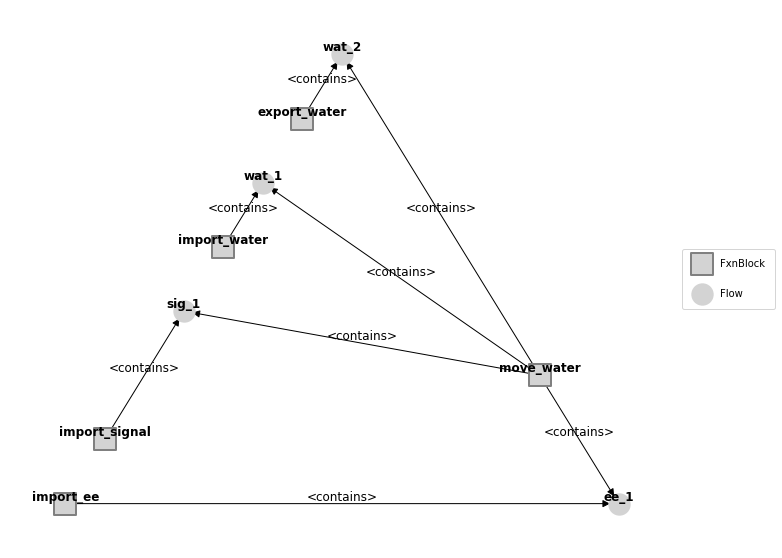

We can also view the flow values of the model using `an.plot.hist` ([see docs](https://nasa.github.io/fmdtools/docs/fmdtools.analyze.html#fmdtools.analyze.plot.hist))


It may be helpful to only view flows of interest.

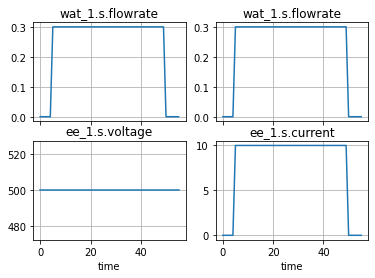

Note: for quick access to the syntax and options for these methods, type the `?method` or `help(method)` in the terminal. For example `?an.plot.mdlhists`

### 2b.) Simulate a fault mode
To simulate the model in a fault scenario, use the `propagate.one_fault` method. The set of possible faults is defined in the function definitions in `ex_pump.py`, and we can propagate a fault at any time in the operational interval (0-55 seconds).

For example, below we simulate a short in the `MoveWater` function at time t=10:

In [40]:
                                                 desired_result=['endclass', 'graph'], track="all")

We can also view the results for from this. In this case `mdlhist` gives a history of results for both the nominal and faulty runs.

endclass.rate:                   0.00055
endclass.cost:        29000.000000000007
endclass.expected cost: 1595000.0000000005
graph: <fmdtools.analyze.graph.ModelGraph object at 0x0000022D84957580>

nominal.i.finished:            array(56)
nominal.i.on:                  array(56)
nominal.fxns.import_ee.s.effstate: array(56)
nominal.fxns.import_ee.m.faults.no_v: array(56)
nominal.fxns.import_ee.m.faults.inf_v: array(56)
nominal.fxns.import_ee.m.mode: array(56)
nominal.fxns.import_           array(56)
nominal.fxns.import_water.m.mode: array(56)
nominal.fxns.import_           array(56)
nominal.fxns.import_signal.m.mode: array(56)
nominal.fxns.move_wa           array(56)
nominal.fxns.move_water.s.eff: array(56)
nominal.fxns.move_wa           array(56)
nominal.fxns.move_water.m.faults.short: array(56)
nominal.fxns.move_water.m.mode: array(56)
nominal.fxns.move_wa           array(56)
nominal.fxns.move_wa           array(56)
nominal.fxns.export_           array(56)
nominal.fxns.export_water.m.mode: array(56)
nominal.flows.ee_1.s.current:  array(56)
nominal.flows.ee_1.s.voltage:  array(56)
nominal.flows.sig_1.s.power:   array(56)
nominal.flows.wat_1.s.flowrate: array(56)
nominal.flows.wat

### 3b.) Visualize fault model states
`an.plot.mdlhistvals` also works for a mdlhists given from `propagate.one_fault`. We can view these results below. As shown, the function will give the nominal result in a blue dotted line and the faulty result in a red line.

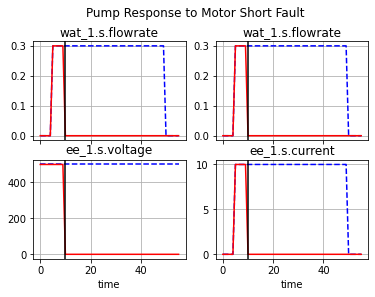

We can also view this result graph using `Graph.draw`. In this case, it shows the state of the model at the final time-step of the model run. Thus, while the `EE_1` flow is shown in orange (because it is off-nominal), the Water flows are not, because they have the same state at the final time-step.

(<Figure size 864x720 with 1 Axes>, <AxesSubplot:>)

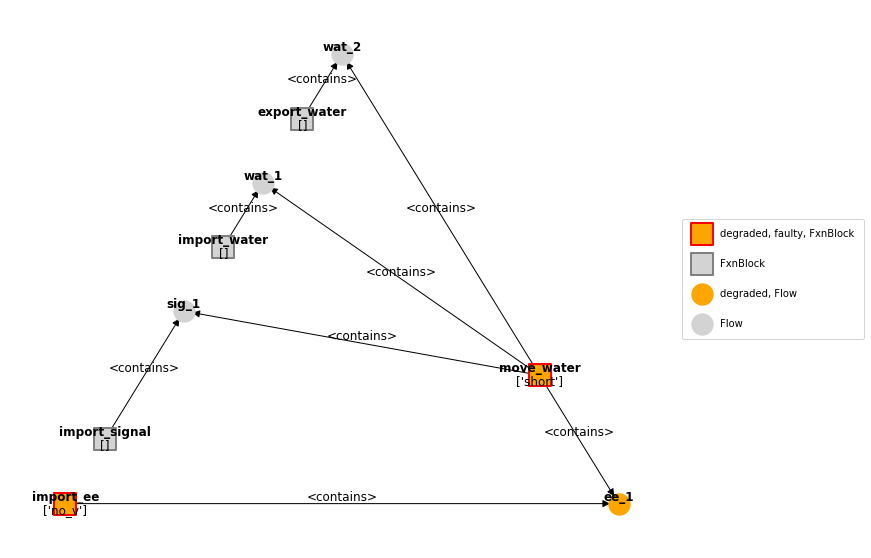

If we want to view the graph at another time-step, we can use `Graph.draw_from`, which will call `History.get_degraded_hist` to first process the model states into results which can be visualized and then map that onto a graph view at a given time.

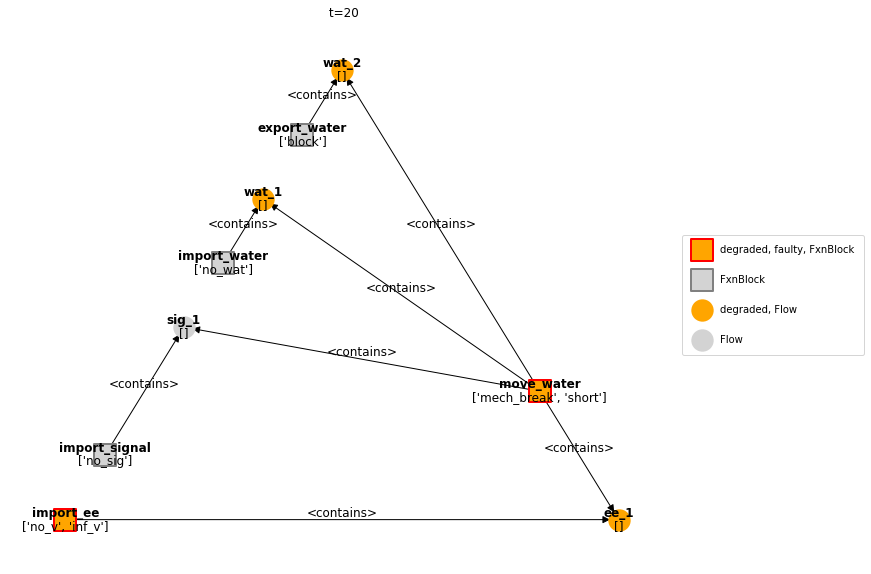

Note that multiple graph representations are available for the graph if desired...

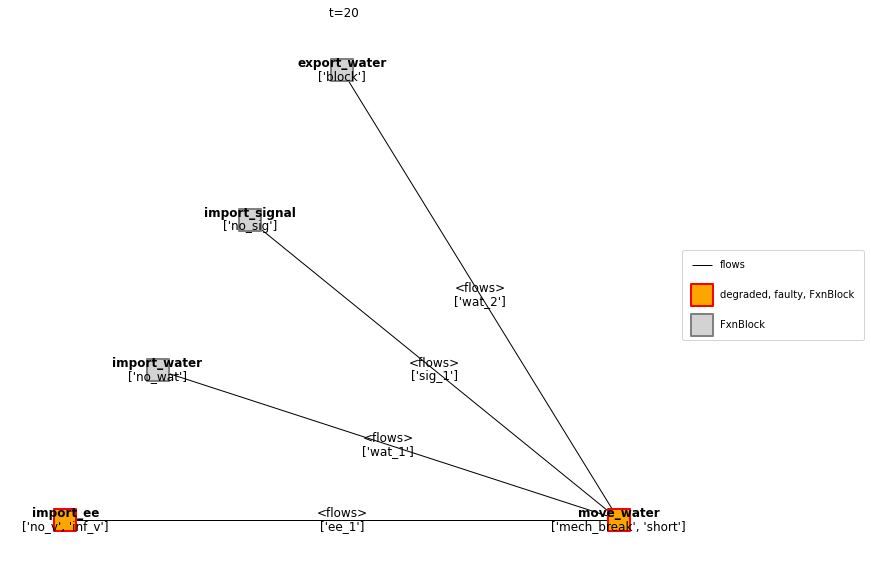

### 4a.) Simulate set of fault modes

To simulate the set of fault modes, we first choose a `SampleApproach`. For simplicity, we can choose default parameters at first.

SCENARIOS COMPLETE: 100%|█████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 127.20it/s]


It can be helpful to view what these results look like--a `Result` of faults injected at particular times with their correspnding `Result` dictionaries.

import_ee_no_v_t27p0.endclass.rate: 0.0003600000000000001
import_ee_no_v_t27p0.endclass.cost: 15174.999999999998
import_ee_no_v_t27p0            546300.0
import_ee_inf_v_t27p0.endclass.rate: 9.000000000000002e-05
import_ee_inf_v_t27p0.endclass.cost: 20175.0
import_ee_inf_v_t27p  181575.00000000003
import_water_no_wat_             0.00015
import_water_no_wat_   6174.999999999998
import_water_no_wat_   92624.99999999996
import_signal_no_sig1.2857142857142856e-05
import_signal_no_sig              8650.0
import_signal_no_sig   11121.42857142857
move_water_mech_brea0.00023142857142857142
move_water_mech_brea  10174.999999999998
move_water_mech_brea   235478.5714285714
move_water_short_t27p0.endclass.rate: 0.00012857142857142858
move_water_short_t27p0.endclass.cost: 25175.0
move_water_short_t27   323678.5714285714
export_water_block_t27p0.endclass.rate: 0.00012857142857142858
export_water_block_t27p0.endclass.cost: 15152.5
export_water_block_t  194817.85714285716
import_water_no_wat_t2p0.end

We can look at/use a more structured version using:

import_water_no_wat_t52p0: 
--endclass: 
----expected cost:    1999.9999999999998
----rate:         1.9999999999999998e-05
----cost:                         1000.0
export_water_block_t27p0: 
--endclass: 
----expected cost:    194817.85714285716
----rate:         0.00012857142857142858
----cost:                        15152.5
move_water_short_t2p0: 
--endclass: 
----expected cost:     64553.57142857144
----rate:         2.1428571428571428e-05
----cost:             30125.000000000007
move_water_short_t52p0: 
--endclass: 
----expected cost:    17142.857142857145
----rate:         1.7142857142857145e-05
----cost:                        10000.0
move_water_mech_break_t27p0: 
--endclass: 
----expected cost:     235478.5714285714
----rate:         0.00023142857142857142
----cost:             10174.999999999998
move_water_mech_break_t52p0: 
--endclass: 
----expected cost:    1285.7142857142858
----rate:         2.5714285714285716e-06
----cost:                         5000.0
import_signal_no_sig

It can be helpful to explore different approach parameters (e.g. focussing on single faults, different numbers of sample points, etc)

[('move_water', 'short')]

There are a number of different ways to sample the scenarios in the approach:

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 12.0,
 20.0,
 27.0,
 34.0,
 42.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0]

### 4b.) Visualize set of fault modes

Using this fault approach, we can now make an FMEA-like analyses of the different fault modes. `an.tabulate.summfmea` organizes endclasses into a table for each fault.

rate  expected cost          cost
move_water    short       0.000167  405375.000000  21766.666667
import_ee     inf_v       0.000090  181575.000000  20175.000000
              no_v        0.000360  546300.000000  15175.000000
export_water  block       0.000167  246466.071429  13418.333333
import_signal no_sig      0.000017   17148.214286  12925.000000
move_water    mech_break  0.000236  240005.357143  10100.000000
import_water  no_wat      0.000187  113166.666667   6100.000000

We can also use `an.result_summary_fmea` with the processed results histories to get a better picture of which flows and functions degrade in each scenario. 

,degraded,faulty,rate,cost,expected cost
import_water_no_wat_t52p0,[],[],0.00002,1000.0,2000.0
export_water_block_t27p0,"['ee_1', 'wat_2']",[],0.000129,15152.5,194817.857143
move_water_short_t2p0,"['ee_1', 'wat_2']",[],0.000021,30125.0,64553.571429
move_water_short_t52p0,[],[],0.000017,10000.0,17142.857143
move_water_mech_break_t27p0,"['ee_1', 'wat_2']",[],0.000231,10175.0,235478.571429
move_water_mech_break_t52p0,[],[],0.000003,5000.0,1285.714286
import_signal_no_sig_t52p0,[],[],0.000002,10000.0,1714.285714
import_signal_no_sig_t27p0,"['ee_1', 'wat_2']",[],0.000013,8650.0,11121.428571
move_water_mech_break_t2p0,"['ee_1', 'wat_2']",[],0.000002,15125.0,3241.071429
import_water_no_wat_t2p0,"['ee_1', 'wat_2']",[],0.000017,11125.0,18541.666667


**Note that this is contingent on what we tracked in the history!** In the above model, we used the default, which is only a few variables defined in the model. 

If we tracked all, on the other hand, we would get the result below:

SCENARIOS COMPLETE: 100%|██████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 73.15it/s]


,degraded,faulty,rate,cost,expected cost
import_water_no_wat_t52p0,"['import_water', 'wat_1']",['import_water'],0.00002,1000.0,2000.0
export_water_block_t27p0,"['move_water', 'export_water', 'ee_1', 'wat_1'...","['move_water', 'export_water']",0.000129,15152.5,194817.857143
move_water_short_t2p0,"['import_ee', 'move_water', 'ee_1', 'wat_1', '...","['import_ee', 'move_water']",0.000021,30125.0,64553.571429
move_water_short_t52p0,['move_water'],['move_water'],0.000017,10000.0,17142.857143
move_water_mech_break_t27p0,"['move_water', 'ee_1', 'wat_1', 'wat_2']",['move_water'],0.000231,10175.0,235478.571429
move_water_mech_break_t52p0,['move_water'],['move_water'],0.000003,5000.0,1285.714286
import_signal_no_sig_t52p0,['import_signal'],['import_signal'],0.000002,10000.0,1714.285714
import_signal_no_sig_t27p0,"['import_signal', 'ee_1', 'sig_1', 'wat_1', 'w...",['import_signal'],0.000013,8650.0,11121.428571
move_water_mech_break_t2p0,"['move_water', 'ee_1', 'wat_1', 'wat_2']",['move_water'],0.000002,15125.0,3241.071429
import_water_no_wat_t2p0,"['import_water', 'ee_1', 'wat_1', 'wat_2']",['import_water'],0.000017,11125.0,18541.666667


## 5.) Saving Work

In computationally expensive simulations, running a lot of computational simulations can take a considerable amount of time. As a result, it becomes impractical to run a new simulation every time one wishes to analyse its data. Results from fmdtools simulations (endclasses or mdlhists) can be saved as pickle, csv, or json files in this instance using either:
- `Result.save`/`History.save` or 
- passing a save_args dictionary to the respective propagate functions (e.g., `{'endclass':{'filename':'file.pkl','overwrite':True}`)

and then loaded using:
- `Result.load`/`History.load`

For example, for this variable:

import_ee_no_v_t27p0.endclass.rate: 0.0003600000000000001
import_ee_no_v_t27p0.endclass.cost: 15174.999999999998
import_ee_no_v_t27p0            546300.0
import_ee_inf_v_t27p0.endclass.rate: 9.000000000000002e-05
import_ee_inf_v_t27p0.endclass.cost: 20175.0
import_ee_inf_v_t27p  181575.00000000003
import_water_no_wat_             0.00015
import_water_no_wat_   6174.999999999998
import_water_no_wat_   92624.99999999996
import_signal_no_sig1.2857142857142856e-05
import_signal_no_sig              8650.0
import_signal_no_sig   11121.42857142857
move_water_mech_brea0.00023142857142857142
move_water_mech_brea  10174.999999999998
move_water_mech_brea   235478.5714285714
move_water_short_t27p0.endclass.rate: 0.00012857142857142858
move_water_short_t27p0.endclass.cost: 25175.0
move_water_short_t27   323678.5714285714
export_water_block_t27p0.endclass.rate: 0.00012857142857142858
export_water_block_t27p0.endclass.cost: 15152.5
export_water_block_t  194817.85714285716
import_water_no_wat_t2p0.end

File already exists: tutorial_endclasses.csv, writing anyway...


import_ee_no_v_t27p0.endclass.rate: 0.00036
import_ee_no_v_t27p0.endclass.cost: 15174.999999999998
import_ee_no_v_t27p0            546300.0
import_ee_inf_v_t27p0.endclass.rate: 9.000000000000002e-05
import_ee_inf_v_t27p0.endclass.cost: 20175.0
import_ee_inf_v_t27p  181575.00000000003
import_water_no_wat_             0.00015
import_water_no_wat_   6174.999999999998
import_water_no_wat_   92624.99999999996
import_signal_no_sig1.2857142857142856e-05
import_signal_no_sig              8650.0
import_signal_no_sig   11121.42857142857
move_water_mech_brea  0.0002314285714285
move_water_mech_brea  10174.999999999998
move_water_mech_brea   235478.5714285714
move_water_short_t27p0.endclass.rate: 0.0001285714285714
move_water_short_t27p0.endclass.cost: 25175.0
move_water_short_t27   323678.5714285714
export_water_block_t27p0.endclass.rate: 0.0001285714285714
export_water_block_t27p0.endclass.cost: 15152.5
export_water_block_t   194817.8571428572
import_water_no_wat_t2p0.endclass.rate: 1.6666666666